In [1]:
import torch, cv2, math
import numpy as np
import matplotlib.pyplot as plt

/home/jinhanz/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Layers Definition

In [2]:
# Hyperparameter Settings
target_layer_group_dict = {
    "model_0_act" : [6,2,2],
    
    "model_1_act": [3,2,1],
    "model_2" : {
        "model_2_cv1_act":[1,1,0],
        "model_2_cv2_act":[1,1,0]
    },
    "model_2_m_0_cv1_act":[1,1,0],
    "model_2_m_0_cv2_act":[3,1,1],
    "model_2_cv3_act":[1,1,0],

    "model_3_act": [3,2,1],
    "model_4" : {
        "model_4_cv1_act":[1,1,0],
        "model_4_cv2_act":[1,1,0]
    },
    "model_4_m_0_cv1_act":[1,1,0],
    "model_4_m_0_cv2_act":[3,1,1],
    "model_4_m_1_cv1_act":[1,1,0],
    "model_4_m_1_cv2_act":[3,1,1],
    "model_4_cv3_act":[1,1,0],

    "model_5_act": [3,2,1],
    "model_6" : {
        "model_6_cv1_act":[1,1,0],
        "model_6_cv2_act":[1,1,0]
    },
    "model_6_m_0_cv1_act":[1,1,0],
    "model_6_m_0_cv2_act":[3,1,1],
    "model_6_m_1_cv1_act":[1,1,0],
    "model_6_m_1_cv2_act":[3,1,1],
    "model_6_m_2_cv1_act":[1,1,0],
    "model_6_m_2_cv2_act":[3,1,1],
    "model_6_cv3_act":[1,1,0],

    "model_7_act": [3,2,1],
    "model_8" : {
        "model_8_cv1_act":[1,1,0],
        "model_8_cv2_act":[1,1,0]
    },
    "model_8_m_0_cv1_act":[1,1,0],
    "model_8_m_0_cv2_act":[3,1,1],
    "model_8_cv3_act":[1,1,0],

    # SPPF
    "model_9_cv1_act":[1,1,0],
    "model_9_m_act1":[5,1,2], # repeated
    "model_9_m_act2":[5,1,2],
    "model_9_m_act3":[5,1,2],
    "model_9_cv2_act":[1,1,0],

    "model_10_act":[1,1,0],
    "model_13" : {
        "model_13_cv1_act":[1,1,0],
        "model_13_cv2_act":[1,1,0]
    },
    "model_13_m_0_cv1_act":[1,1,0],
    "model_13_m_0_cv2_act":[3,1,1],
    "model_13_cv3_act":[1,1,0],

    "model_14_act":[1,1,0],
    "model_17" : {
        "model_17_cv1_act":[1,1,0],
        "model_17_cv2_act":[1,1,0]
    },
    "model_17_m_0_cv1_act":[1,1,0],
    "model_17_m_0_cv2_act":[3,1,1],
    "model_17_cv3_act":[1,1,0],

    "model_18_act":[3,2,1],
    "model_20" : {
        "model_20_cv1_act":[1,1,0],
        "model_20_cv2_act":[1,1,0]
    },
    "model_20_m_0_cv1_act":[1,1,0],
    "model_20_m_0_cv2_act":[3,1,1],
    "model_20_cv3_act":[1,1,0],

    "model_21_act":[3,2,1],
    "model_23" : {
        "model_23_cv1_act":[1,1,0],
        "model_23_cv2_act":[1,1,0]
    },
    "model_23_m_0_cv1_act":[1,1,0],
    "model_23_m_0_cv2_act":[3,1,1],
    "model_23_cv3_act":[1,1,0],    
}

## Main Functions

In [3]:
def calculate_receptive_field(layer_name, layers, upsample_factor=1):
    """
    Calculate the receptive field, stride, and padding for a specific layer in a CNN.
    Args:
    - layer_name (str): Index of the layer.
    - layers (list): List of layer properties (kernel size, stride, padding).
        For yolov5s, e.g. model_2_cv1_act and model_2_cv2_act are parallel and grouped in a dict

    Returns:
    - receptive_field (N, 2): Size of the receptive field in both dimensions
    - jump (N, 2): Jump of the receptive field (in both dimensions). (Product of strides used)
    - start (N, 2): center coordinates of the first feature (top-left)
        (N=1 for the backbone layers)
    """

    receptive_field = np.full((1, 2), 1.0)
    jump = np.full((1, 2), 1.0)
    start = np.full((1, 2), 0.5)

    for layer in layers:

        if isinstance(layers[layer],dict):
            kernel_size, layer_stride, layer_padding = list(layers[layer].values())[0]
        else:
            kernel_size, layer_stride, layer_padding = layers[layer]

        receptive_field[:, 0] += (kernel_size - 1) * jump[:, 0]
        receptive_field[:, 1] += (kernel_size - 1) * jump[:, 1]

        start[:, 0] += ((kernel_size - 1) / 2 - layer_padding) * jump[:, 0]
        start[:, 1] += ((kernel_size - 1) / 2 - layer_padding) * jump[:, 1]

        jump[:, 0] *= layer_stride
        jump[:, 1] *= layer_stride

        # Adjust jump and start based on upsampling
        if layer in ["model_13","model_17"]:
            upsample_factor = 2
            jump[:, 0] /= upsample_factor
            jump[:, 1] /= upsample_factor
            start[:, 0] /= upsample_factor
            start[:, 1] /= upsample_factor

        # print(f"{layer} r={receptive_field}")

        if isinstance(layers[layer],dict):
            if layer_name in layers[layer]:
                break
        elif layer == layer_name:
            break

    return receptive_field, jump, start

def map_saliency_to_original_image(saliency_map, original_size, preprocessed_size, 
                                   jump, start):
    """
    Map saliency map locations to the centers of their receptive fields on the original image.
    Args:
    - saliency_map (ndarray): The saliency map.
    - original_size (tuple): The size of the original image.
    - preprocessed_size (tuple): The size of the preprocessed image.
    - receptive_field (N, 2): Size of the receptive field in both dimensions
    - jump (N, 2): Jump of the receptive field (in both dimensions). (Product of strides used)
    - start (N, 2): center coordinates of the first feature (top-left)

    Returns:
    - mapped_locs (ndarray): Mapped locations on the original image.
    """
    saliency_height, saliency_width = saliency_map.shape[2],saliency_map.shape[3]
    original_height, original_width = original_size
    preprocessed_height, preprocessed_width = preprocessed_size

    height_ratio = original_height / preprocessed_height
    width_ratio = original_width / preprocessed_width

    # Create a grid of indices
    x_indices, y_indices = np.meshgrid(np.arange(saliency_width), np.arange(saliency_height))

    # Expand the indices to match the number of proposals for broadcasting
    x_indices = np.expand_dims(x_indices, axis=0)  # Shape: (1, saliency_height, saliency_width)
    y_indices = np.expand_dims(y_indices, axis=0)

    jump_x = jump[:, 0, np.newaxis, np.newaxis]  # Shape: (num_instances, 1, 1)
    jump_y = jump[:, 1, np.newaxis, np.newaxis]
    start_x = start[:, 0, np.newaxis, np.newaxis]
    start_y = start[:, 1, np.newaxis, np.newaxis]

    # Calculate the center positions in the preprocessed image
    center_x = x_indices * jump_x + start_x # Shape: (1, saliency_height, saliency_width)
    center_y = y_indices * jump_y + start_y

    # Map to original image coordinates
    mapped_center_x = (center_x * width_ratio).astype(int)
    mapped_center_y = (center_y * height_ratio).astype(int)

    # Stack the mapped coordinates into the output array
    mapped_locs = np.stack((mapped_center_x, mapped_center_y), axis=-1)

    return mapped_locs

def apply_gaussian_kernel(saliency_map, mapped_locs, receptive_field, original_size, sigma_factor=2):
    """
    Apply Gaussian kernel to the saliency map locations and upsample to the original image size.
    Args:
    - saliency_map (N,C,H,W): N=#proposals for head and N=1 for backone. C=1 (summed over channls in fullgradcam)
    - mapped_locs (N,H,W,2): Mapped locations on the original image.
    - receptive_field (N,2): Size of the receptive field in x and y dimension
    - original_size (tuple): The size of the original image.

    Returns:
    - output (ndarray): Saliency map upsampled to the original image size.
    """
    N, C, saliency_height, saliency_width = saliency_map.shape
    original_height, original_width = original_size
    output = np.zeros((N, C, original_height, original_width), dtype=np.float32) #TODO

    saliency_map = saliency_map.cpu().detach().numpy()

    for n in range(N):
        # debug
        sigma_x = receptive_field[n, 0] / sigma_factor
        sigma_y = receptive_field[n, 1] / sigma_factor

        kernel_size_x = math.ceil(sigma_x * 6)
        kernel_size_y = math.ceil(sigma_y * 6)
        if kernel_size_x % 2 == 0: kernel_size_x += 1
        if kernel_size_y % 2 == 0: kernel_size_y += 1

        gaussian_x = cv2.getGaussianKernel(ksize=kernel_size_x, sigma=sigma_x)
        gaussian_y = cv2.getGaussianKernel(ksize=kernel_size_y, sigma=sigma_y)
        gaussian = gaussian_y * gaussian_x.T  # Create 2D Gaussian kernel
        h, w = gaussian.shape

        center_x = mapped_locs[n, :, :, 0].astype(int)
        center_y = mapped_locs[n, :, :, 1].astype(int)

        # Determine the region in the output array
        sx = np.maximum(center_x - w // 2, 0)
        ex = np.minimum(center_x + w // 2 + 1, original_width)
        sy = np.maximum(center_y - h // 2, 0)
        ey = np.minimum(center_y + h // 2 + 1, original_height)

        # Determine the relative region in the gaussian kernel
        gsx = np.maximum(0, w // 2 - (center_x - sx))
        gex = gsx + (ex - sx)
        gsy = np.maximum(0, h // 2 - (center_y - sy))
        gey = gsy + (ey - sy)

        for i in range(saliency_height):
            for j in range(saliency_width):
                cx, cy = center_x[i, j], center_y[i, j]
                if 0 <= cx < original_width and 0 <= cy < original_height:
                    output[n, 0, sy[i, j]:ey[i, j], sx[i, j]:ex[i, j]] += (
                        saliency_map[n, 0, i, j] * gaussian[gsy[i, j]:gey[i, j], gsx[i, j]:gex[i, j]]
                    )

    return torch.tensor(output)

## Initialize Test Maps

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.]])


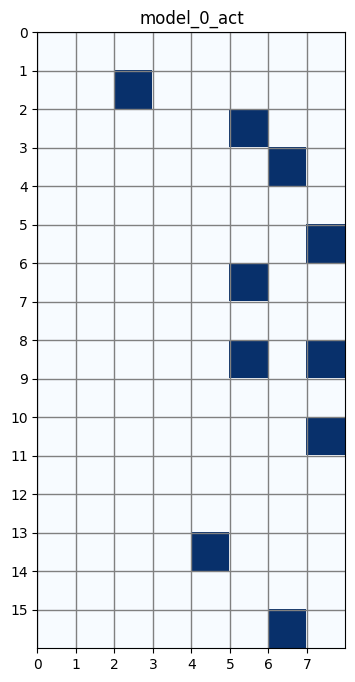

tensor([[1., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.]])


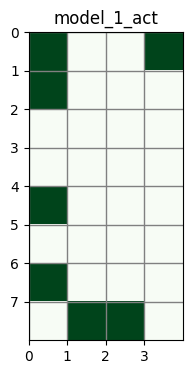

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


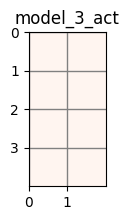

In [4]:
orig_img_size = (32,16)

sparsity = 0.2

test_maps = {
    "model_0_act": torch.bernoulli(torch.full((1,1, 16, 8), sparsity)),
    "model_1_act": torch.bernoulli(torch.full((1,1, 8, 4), sparsity)),
    "model_3_act": torch.bernoulli(torch.full((1,1, 4, 2), sparsity)),
}

cmap_code = {
    "model_0_act": "Blues",
    "model_1_act": "Greens",
    "model_3_act": "Reds",
}

dot_code = {
    "model_0_act": "bo",
    "model_1_act": "go",
    "model_3_act": "ro",
}

for i, (layer_name, test_map) in enumerate(test_maps.items()):

    test_map = test_map[0][0]

    print(test_map)

    plt.figure(figsize=(test_map.shape))

    h, w = test_map.shape
    # Plotting
    plt.imshow(test_map, cmap=cmap_code[layer_name], interpolation='none',
               extent=[0, w, h, 0])

    # Adding gridlines
    plt.grid(which='both', color='grey', linestyle='-', linewidth=1)

    # Set major ticks at every unit
    plt.xticks(range(w))
    plt.yticks(range(h))

    # # Adjust gridlines to align with the cell boundaries
    # plt.xticks([x - 0.5 for x in range(1, w)], minor=True)
    # plt.yticks([y - 0.5 for y in range(1, h)], minor=True)

    # Set title
    plt.title(layer_name)

    # Set the axis limits to the actual tensor size, so no extra space is shown
    # plt.xlim([-0.5, w - 0.5])
    # plt.ylim([h - 0.5, -0.5])

    # Adjust layout and show the plot
    plt.show()

## Usage

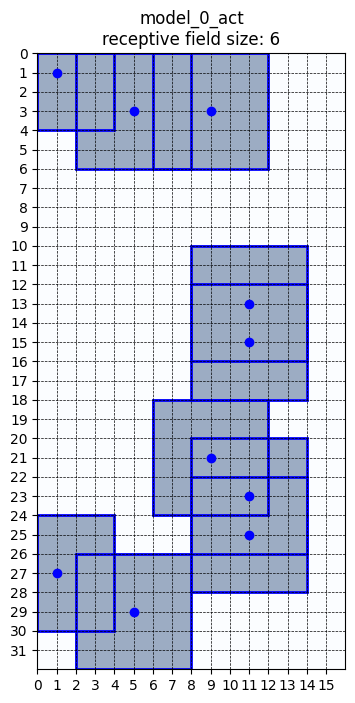

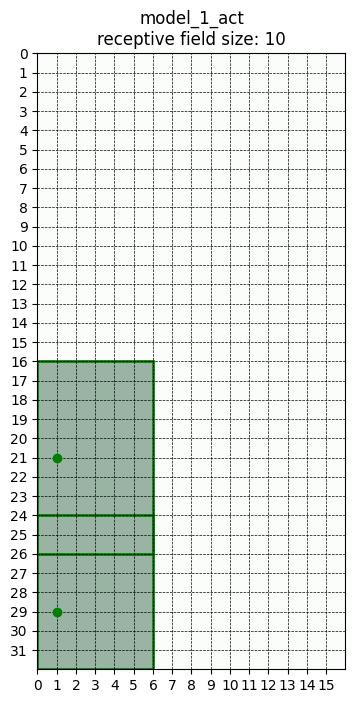

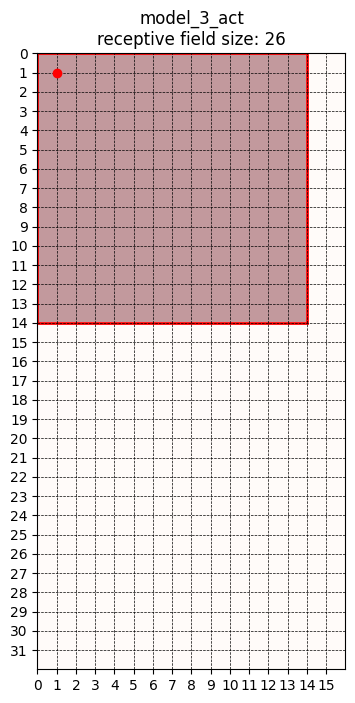

In [31]:
from matplotlib.patches import Rectangle

def visualize_saliency_with_grid(image_size, saliency_map, mapped_locs, layer_name, receptive_field, 
                                 saliency_map_prev=None, mapped_locs_prev=None, layer_name_prev=None, effective_mask_prev=None):
    """
    Visualize the saliency map on a blank canvas using imshow and overlay a grid to show the mapping.
    
    Args:
    - image_size (tuple): The size of the original image (height, width).
    - saliency_map (torch.Tensor): The saliency map (N, C, H, W).
    - mapped_locs (ndarray): The mapped locations (N, H, W, 2) from the saliency map to the original image.
    - layer_name (str)
    - receptive_field (ndarray): The theoretical receptive field size on each dimension (N, 2)

    Return:
    - effective_mask: (N,H,W) in the size of the original image. entry value = 1 if this location is 
        within the effective receptive field of any activated locations on this saliency map
    - effective_receptive_field: (N,H,W,2)
    """
    height, width = image_size
    N, C, saliency_height, saliency_width = saliency_map.shape

    rx, ry = receptive_field[0]

    # Squeeze saliency map if it's a single-channel map
    saliency_map = saliency_map.squeeze()  # Assuming C=1 for simplicity

    # Create a mask the size of the original image
    theoretical_mask = torch.zeros((height, width)) # activated theoretical receptive field
    effective_mask = torch.zeros((height, width))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Overlay a grid to represent the saliency map structure
    ax.set_xticks(np.arange(0, width))
    ax.set_yticks(np.arange(0, height))
    ax.grid(True, color='black', linestyle='--', linewidth=0.5)

    # Plot the mapped locations as points on the grid
    for i in range(saliency_height):
        for j in range(saliency_width):
            cx, cy = mapped_locs[0, i, j, 0], mapped_locs[0, i, j, 1]
            if saliency_map[i][j] > 0:
                ax.plot(cx, cy, dot_code[layer_name])  # Red dots representing the activated mapped locations

                # Calculate the bounds of the receptive field
                x_start = max(int(cx - rx // 2), 0)
                x_end = min(int(cx + rx // 2), width)
                y_start = max(int(cy - ry // 2), 0)
                y_end = min(int(cy + ry // 2), height)

                # Create and add the rectangle based on start and end coordinates
                rect_width = x_end - x_start
                rect_height = y_end - y_start
                rect = Rectangle((x_start, y_start), rect_width, rect_height,
                                 linewidth=2, edgecolor=dot_code[layer_name][0], facecolor='none')
                ax.add_patch(rect)

                # Set the pixels within the receptive field to 1 in the mask
                theoretical_mask[y_start:y_end, x_start:x_end] = 1

    # Plot the saliency map on the blank background using imshow
    ax.imshow(theoretical_mask, cmap=cmap_code[layer_name], alpha=0.4, 
              interpolation='none', origin='upper', extent=[0, width, height, 0],
              vmin=0, vmax=1)
    
    # if layer_name != 'model_0_act':
    #     saliency_map_prev = saliency_map_prev.squeeze()
    #     for i in range(saliency_map_prev.shape[0]):
    #         for j in range(saliency_map_prev.shape[1]):
    #             cx, cy = mapped_locs_prev[0, i, j, 0], mapped_locs_prev[0, i, j, 1]
    #             if saliency_map_prev[i][j] > 0:
    #                 ax.plot(cx, cy, dot_code[layer_name_prev])  # Red dots representing the activated mapped locations

    #     ax.imshow(effective_mask_prev, cmap=cmap_code[layer_name_prev], alpha=0.2, 
    #             interpolation='none', origin='upper', extent=[0, width, height, 0],
    #             vmin=0, vmax=1)

    # Set labels and title
    # ax.set_xlabel("Width")
    # ax.set_ylabel("Height")
    ax.set_title(f"{layer_name}\nreceptive field size: {int(receptive_field[0][0])}")

    plt.show()

    return theoretical_mask

max_rows = max(tensor.shape[2] for tensor in test_maps.values())
max_cols = max(tensor.shape[3] for tensor in test_maps.values())

# fig, axs = plt.subplots(1, 3, figsize=(3 * max_cols, max_rows))

h, w = orig_img_size
h_orig, w_orig = h, w

saliency_map_prev = None
mapped_locs_prev = None
effective_mask_prev = None
layer_name_prev = None

for i, (layer_name, test_map) in enumerate(test_maps.items()):

    receptive_field, jump, start = calculate_receptive_field(layer_name, target_layer_group_dict)

    # Adjust the receptive field to account for the input resizing in preprocessing
    height_ratio = h_orig / h
    width_ratio = w_orig / w
    adjusted_receptive_field = receptive_field
    adjusted_receptive_field[:,0] = receptive_field[:,0] * width_ratio
    adjusted_receptive_field[:,1] = receptive_field[:,1] * height_ratio

    # print(f"Receptive field: {receptive_field}, adjusted: {adjusted_receptive_field}")

    # Get a grid of coordinates of the receptive field center of each spatial location of the intermediate saliency map, 
    #   mapped to the original image
    mapped_locs = map_saliency_to_original_image(test_map, (h_orig,w_orig), (h,w), jump, start)

    effective_mask_prev = visualize_saliency_with_grid(orig_img_size, test_map, mapped_locs, layer_name, adjusted_receptive_field,
                                                       saliency_map_prev, mapped_locs_prev, layer_name_prev, effective_mask_prev)
    saliency_map_prev = test_map
    mapped_locs_prev = mapped_locs
    layer_name_prev = layer_name

    # saliency_map = apply_gaussian_kernel(test_map, mapped_locs, adjusted_receptive_field, (h_orig,w_orig), sigma_factor=4).sum(0,keepdim=True)    


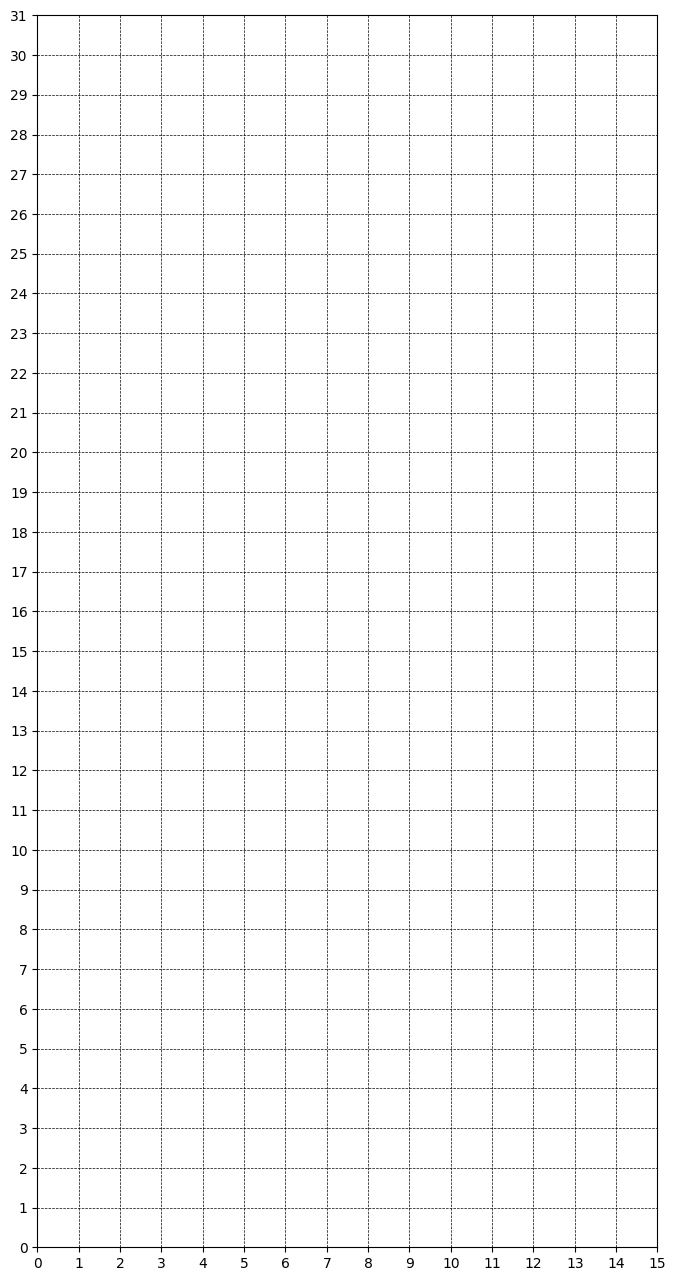

In [30]:
plt.figure(figsize=(8,16))
plt.xticks(np.arange(0, orig_img_size[1]))
plt.yticks(np.arange(0, orig_img_size[0]))
plt.grid(True, color='black', linestyle='--', linewidth=0.5)

plt.show()

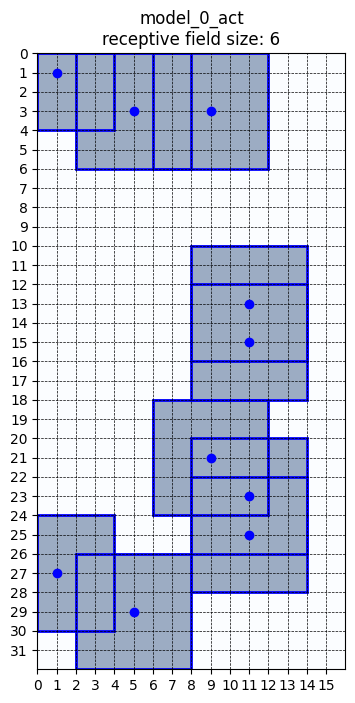

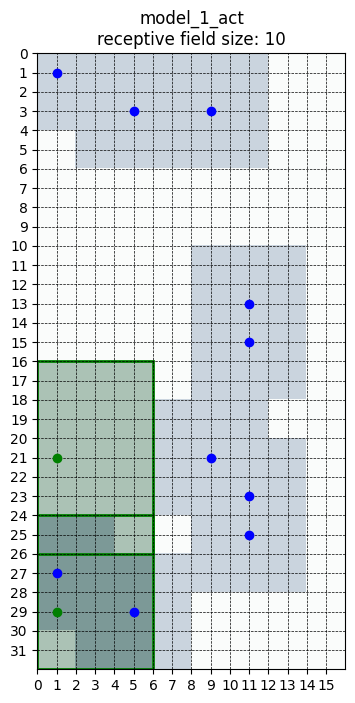

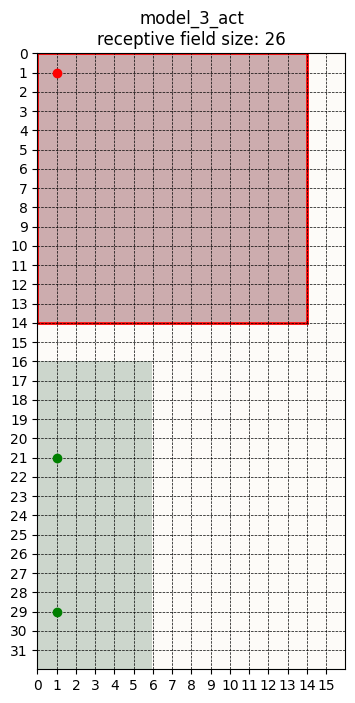

In [32]:
from matplotlib.patches import Rectangle

def visualize_saliency_with_grid(image_size, saliency_map, mapped_locs, layer_name, receptive_field, 
                                 saliency_map_prev=None, mapped_locs_prev=None, layer_name_prev=None, effective_mask_prev=None):
    """
    Visualize the saliency map on a blank canvas using imshow and overlay a grid to show the mapping.
    
    Args:
    - image_size (tuple): The size of the original image (height, width).
    - saliency_map (torch.Tensor): The saliency map (N, C, H, W).
    - mapped_locs (ndarray): The mapped locations (N, H, W, 2) from the saliency map to the original image.
    - layer_name (str)
    - receptive_field (ndarray): The theoretical receptive field size on each dimension (N, 2)

    Return:
    - effective_mask: (N,H,W) in the size of the original image. entry value = 1 if this location is 
        within the effective receptive field of any activated locations on this saliency map
    - effective_receptive_field: (N,H,W,2)
    """
    height, width = image_size
    N, C, saliency_height, saliency_width = saliency_map.shape

    rx, ry = receptive_field[0]

    # Squeeze saliency map if it's a single-channel map
    saliency_map = saliency_map.squeeze()  # Assuming C=1 for simplicity

    # Create a mask the size of the original image
    theoretical_mask = torch.zeros((height, width)) # activated theoretical receptive field
    effective_mask = torch.zeros((height, width))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Overlay a grid to represent the saliency map structure
    ax.set_xticks(np.arange(0, width))
    ax.set_yticks(np.arange(0, height))
    ax.grid(True, color='black', linestyle='--', linewidth=0.5)

    # Plot the mapped locations as points on the grid
    for i in range(saliency_height):
        for j in range(saliency_width):
            cx, cy = mapped_locs[0, i, j, 0], mapped_locs[0, i, j, 1]
            if saliency_map[i][j] > 0:
                ax.plot(cx, cy, dot_code[layer_name])  # Red dots representing the activated mapped locations

                # Calculate the bounds of the receptive field
                x_start = max(int(cx - rx // 2), 0)
                x_end = min(int(cx + rx // 2), width)
                y_start = max(int(cy - ry // 2), 0)
                y_end = min(int(cy + ry // 2), height)

                # Create and add the rectangle based on start and end coordinates
                rect_width = x_end - x_start
                rect_height = y_end - y_start
                rect = Rectangle((x_start, y_start), rect_width, rect_height,
                                 linewidth=2, edgecolor=dot_code[layer_name][0], facecolor='none')
                ax.add_patch(rect)

                # Set the pixels within the receptive field to 1 in the mask
                theoretical_mask[y_start:y_end, x_start:x_end] = 1

    # Plot the saliency map on the blank background using imshow
    ax.imshow(theoretical_mask, cmap=cmap_code[layer_name], alpha=0.4, 
              interpolation='none', origin='upper', extent=[0, width, height, 0],
              vmin=0, vmax=1)
    
    if layer_name != 'model_0_act':
        saliency_map_prev = saliency_map_prev.squeeze()
        for i in range(saliency_map_prev.shape[0]):
            for j in range(saliency_map_prev.shape[1]):
                cx, cy = mapped_locs_prev[0, i, j, 0], mapped_locs_prev[0, i, j, 1]
                if saliency_map_prev[i][j] > 0:
                    ax.plot(cx, cy, dot_code[layer_name_prev])  # Red dots representing the activated mapped locations

        ax.imshow(effective_mask_prev, cmap=cmap_code[layer_name_prev], alpha=0.2, 
                interpolation='none', origin='upper', extent=[0, width, height, 0],
                vmin=0, vmax=1)

    # Set labels and title
    # ax.set_xlabel("Width")
    # ax.set_ylabel("Height")
    ax.set_title(f"{layer_name}\nreceptive field size: {int(receptive_field[0][0])}")

    plt.show()

    return theoretical_mask

max_rows = max(tensor.shape[2] for tensor in test_maps.values())
max_cols = max(tensor.shape[3] for tensor in test_maps.values())

# fig, axs = plt.subplots(1, 3, figsize=(3 * max_cols, max_rows))

h, w = orig_img_size
h_orig, w_orig = h, w

saliency_map_prev = None
mapped_locs_prev = None
effective_mask_prev = None
layer_name_prev = None

for i, (layer_name, test_map) in enumerate(test_maps.items()):

    receptive_field, jump, start = calculate_receptive_field(layer_name, target_layer_group_dict)

    # Adjust the receptive field to account for the input resizing in preprocessing
    height_ratio = h_orig / h
    width_ratio = w_orig / w
    adjusted_receptive_field = receptive_field
    adjusted_receptive_field[:,0] = receptive_field[:,0] * width_ratio
    adjusted_receptive_field[:,1] = receptive_field[:,1] * height_ratio

    # print(f"Receptive field: {receptive_field}, adjusted: {adjusted_receptive_field}")

    # Get a grid of coordinates of the receptive field center of each spatial location of the intermediate saliency map, 
    #   mapped to the original image
    mapped_locs = map_saliency_to_original_image(test_map, (h_orig,w_orig), (h,w), jump, start)

    effective_mask_prev = visualize_saliency_with_grid(orig_img_size, test_map, mapped_locs, layer_name, adjusted_receptive_field,
                                                       saliency_map_prev, mapped_locs_prev, layer_name_prev, effective_mask_prev)
    saliency_map_prev = test_map
    mapped_locs_prev = mapped_locs
    layer_name_prev = layer_name

    # saliency_map = apply_gaussian_kernel(test_map, mapped_locs, adjusted_receptive_field, (h_orig,w_orig), sigma_factor=4).sum(0,keepdim=True)    


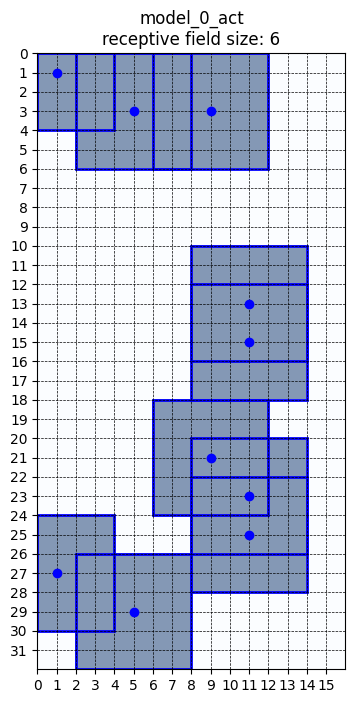

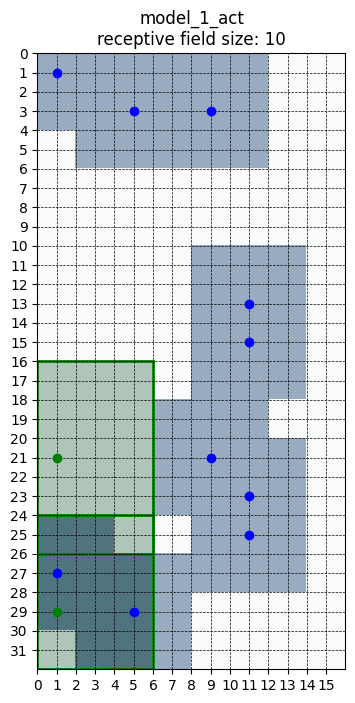

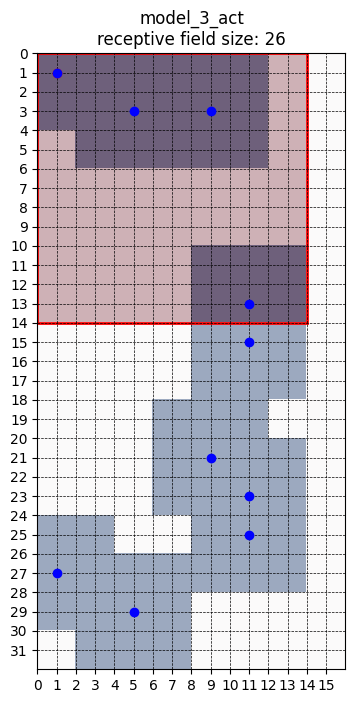

In [36]:
from matplotlib.patches import Rectangle

def visualize_saliency_with_grid(image_size, saliency_map, mapped_locs, layer_name, receptive_field, 
                                 saliency_map_prev=None, mapped_locs_prev=None, layer_name_prev=None, effective_mask_prev=None):
    """
    Visualize the saliency map on a blank canvas using imshow and overlay a grid to show the mapping.
    
    Args:
    - image_size (tuple): The size of the original image (height, width).
    - saliency_map (torch.Tensor): The saliency map (N, C, H, W).
    - mapped_locs (ndarray): The mapped locations (N, H, W, 2) from the saliency map to the original image.
    - layer_name (str)
    - receptive_field (ndarray): The theoretical receptive field size on each dimension (N, 2)

    Return:
    - effective_mask: (N,H,W) in the size of the original image. entry value = 1 if this location is 
        within the effective receptive field of any activated locations on this saliency map
    - effective_receptive_field: (N,H,W,2)
    """
    height, width = image_size
    N, C, saliency_height, saliency_width = saliency_map.shape

    rx, ry = receptive_field[0]

    # Squeeze saliency map if it's a single-channel map
    saliency_map = saliency_map.squeeze()  # Assuming C=1 for simplicity

    # Create a mask the size of the original image
    theoretical_mask = torch.zeros((height, width)) # activated theoretical receptive field
    effective_mask = torch.zeros((height, width))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Overlay a grid to represent the saliency map structure
    ax.set_xticks(np.arange(0, width))
    ax.set_yticks(np.arange(0, height))
    ax.grid(True, color='black', linestyle='--', linewidth=0.5)

    # Plot the mapped locations as points on the grid
    for i in range(saliency_height):
        for j in range(saliency_width):
            cx, cy = mapped_locs[0, i, j, 0], mapped_locs[0, i, j, 1]
            if saliency_map[i][j] > 0:
                ax.plot(cx, cy, dot_code[layer_name])  # Red dots representing the activated mapped locations

                # Calculate the bounds of the receptive field
                x_start = max(int(cx - rx // 2), 0)
                x_end = min(int(cx + rx // 2), width)
                y_start = max(int(cy - ry // 2), 0)
                y_end = min(int(cy + ry // 2), height)

                # Create and add the rectangle based on start and end coordinates
                rect_width = x_end - x_start
                rect_height = y_end - y_start
                rect = Rectangle((x_start, y_start), rect_width, rect_height,
                                 linewidth=2, edgecolor=dot_code[layer_name][0], facecolor='none')
                ax.add_patch(rect)

                # Set the pixels within the receptive field to 1 in the mask
                theoretical_mask[y_start:y_end, x_start:x_end] = 1

    # Plot the saliency map on the blank background using imshow
    ax.imshow(theoretical_mask, cmap=cmap_code[layer_name], alpha=0.5, 
              interpolation='none', origin='upper', extent=[0, width, height, 0],
              vmin=0, vmax=1)
    
    if layer_name != 'model_0_act':
        saliency_map_prev = saliency_map_prev.squeeze()
        for i in range(saliency_map_prev.shape[0]):
            for j in range(saliency_map_prev.shape[1]):
                cx, cy = mapped_locs_prev[0, i, j, 0], mapped_locs_prev[0, i, j, 1]
                if saliency_map_prev[i][j] > 0:
                    ax.plot(cx, cy, dot_code[layer_name_prev])  # Red dots representing the activated mapped locations

        ax.imshow(effective_mask_prev, cmap=cmap_code[layer_name_prev], alpha=0.4, 
                interpolation='none', origin='upper', extent=[0, width, height, 0],
                vmin=0, vmax=1)

    # Set labels and title
    # ax.set_xlabel("Width")
    # ax.set_ylabel("Height")
    ax.set_title(f"{layer_name}\nreceptive field size: {int(receptive_field[0][0])}")

    plt.show()

    return theoretical_mask

max_rows = max(tensor.shape[2] for tensor in test_maps.values())
max_cols = max(tensor.shape[3] for tensor in test_maps.values())

# fig, axs = plt.subplots(1, 3, figsize=(3 * max_cols, max_rows))

h, w = orig_img_size
h_orig, w_orig = h, w

saliency_map_prev = None
mapped_locs_prev = None
effective_mask_prev = None
layer_name_prev = None

for i, (layer_name, test_map) in enumerate(test_maps.items()):

    receptive_field, jump, start = calculate_receptive_field(layer_name, target_layer_group_dict)

    # Adjust the receptive field to account for the input resizing in preprocessing
    height_ratio = h_orig / h
    width_ratio = w_orig / w
    adjusted_receptive_field = receptive_field
    adjusted_receptive_field[:,0] = receptive_field[:,0] * width_ratio
    adjusted_receptive_field[:,1] = receptive_field[:,1] * height_ratio

    # print(f"Receptive field: {receptive_field}, adjusted: {adjusted_receptive_field}")

    # Get a grid of coordinates of the receptive field center of each spatial location of the intermediate saliency map, 
    #   mapped to the original image
    mapped_locs = map_saliency_to_original_image(test_map, (h_orig,w_orig), (h,w), jump, start)

    effective_mask = visualize_saliency_with_grid(orig_img_size, test_map, mapped_locs, layer_name, adjusted_receptive_field,
                                                       saliency_map_prev, mapped_locs_prev, layer_name_prev, effective_mask_prev)
    
    if layer_name == 'model_0_act':
        effective_mask_prev = effective_mask
        saliency_map_prev = test_map
        mapped_locs_prev = mapped_locs
        layer_name_prev = layer_name

    # saliency_map = apply_gaussian_kernel(test_map, mapped_locs, adjusted_receptive_field, (h_orig,w_orig), sigma_factor=4).sum(0,keepdim=True)    
